# More work on the high res testing notebook, copied here to avoid disturbing the original

interactive(children=(FloatSlider(value=2.75, description='phaseOffset', layout=Layout(width='100%'), max=6.28…

<function __main__.SampleAndPlot(phaseOffset)>

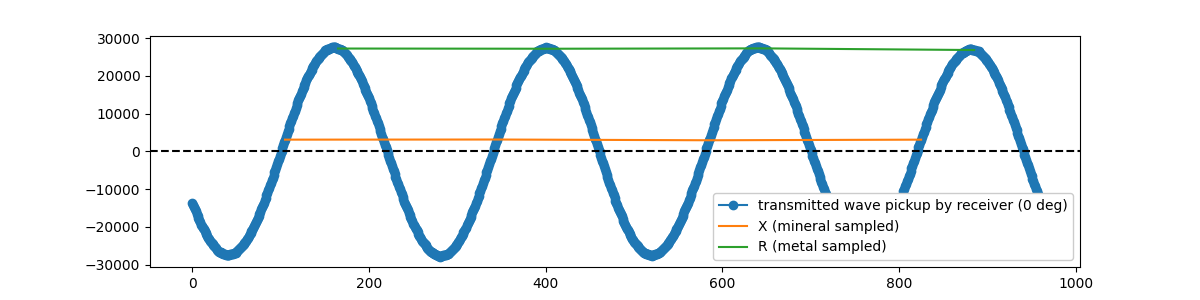

In [1]:
%matplotlib widget
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from ipywidgets import interact, FloatSlider, IntSlider, Layout
import scipy.signal as signal

plt.rcParams['figure.figsize'] = [12, 4]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower

sampleRate = 192000
frequency = 8000

#filename = r"2022_02_25 17_57_52 MST 192000 SPS 16000.0 Hz 20 vol playing (air).txt"
#filename = r"2022_02_25 17_58_12 MST 192000 SPS 16000.0 Hz 20 vol playing (air then ground).txt"
#filename = r"2022_02_25 17_58_33 MST 192000 SPS 16000.0 Hz 20 vol playing (quarter).txt"
#filename = r"2022_02_25 17_58_52 MST 192000 SPS 16000.0 Hz 20 vol playing (sword guard).txt"
#filename = r"2022_02_25 17_59_10 MST 192000 SPS 16000.0 Hz 20 vol playing (ground).txt"
filename = "2022_03_10 17_21_44 MST 192000 SPS 8000.0 Hz 20 vol.txt"

signalData = pd.read_csv(filename, header=None).to_numpy()[:,0]
signalData = signalData[1000:-1]#remove the beginning, where the phase is kind of weird thanks to a recording jitter
numPoints = signalData.shape[0]
signalDataIndices = np.arange(0, numPoints)

#interpolate to get finer phase adjustments, and closer to the zero crossings
#TODO: interpolate surrounding points when sampling instead of all points?
signalData = np.interp(np.arange(0, numPoints, 0.1), np.arange(0, numPoints, 1), signalData)
sampleRate = sampleRate * 10
numPoints = signalData.shape[0]
signalDataIndices = np.arange(0, numPoints)

#print("num points: ", numPoints)
#print("seconds: ", numPoints/sampleRate)

#firFilter = signal.firwin(201, cutoff = 500, window = "hamming", pass_zero = "lowpass", fs=sampleRate)

fig = plt.figure(figsize=(12, 3))
def SampleAndPlot(phaseOffset):
    offsetInSamples = int(round(phaseOffset / (math.pi*2) * sampleRate * 1.0 / frequency, 0))
    print("offset in samples: ", offsetInSamples)

    periodInSamples = int(round(sampleRate * 1.0 / frequency, 0))
    print("period in samples: ", periodInSamples)
    quarterPeriodInSamples = int(round(math.pi/2 / (math.pi*2) * sampleRate * 1.0 / frequency, 0))
    print("quarter period in samples: ", quarterPeriodInSamples)

    signalXList = []
    signalXIndicesList = []
    for i in range(offsetInSamples, numPoints, periodInSamples):
        signalXList.append(signalData[i])
        signalXIndicesList.append(i)
    signalX = np.asarray(signalXList)
    signalXIndices = np.asarray(signalXIndicesList)

    signalRList = []
    signalRIndicesList = []
    for i in range(offsetInSamples + quarterPeriodInSamples, numPoints, periodInSamples):
        signalRList.append(signalData[i])
        signalRIndicesList.append(i)
    signalR = np.asarray(signalRList)
    signalRIndices = np.asarray(signalRIndicesList)

    #make arrays the same size
    if (signalR.size != signalX.size):
        minSize = min([signalR.size, signalX.size])
        signalR = signalR[0:minSize-1]
        signalRIndices = signalRIndices[0:minSize-1]
        signalX = signalX[0:minSize-1]
        signalXIndices = signalXIndices[0:minSize-1]

    #NOTE: this delays the start of the array from moving until the filter length is reached, watch out when plotting
    #signalX = signal.lfilter(firFilter, 1, signalX)
    #signalR = signal.lfilter(firFilter, 1, signalR)
    
    #exampleMineralWave = 10000*np.sin(2*math.pi*frequency/sampleRate*np.arange(numPoints) - 3.18 + math.radians(-7) + math.radians(90))#offset -7 degrees to match where I happened to start recording this dataset
    #exampleCoinWave = 10000*np.sin(2*math.pi*frequency/sampleRate*np.arange(numPoints) - 3.18 + math.radians(-7) + math.radians(-80))#offset -7 degrees to match where I happened to start recording this dataset
    
    gsi = int(0)#numPoints/2)
    gr = int(numPoints/8000)
    gsi2 = int(gsi/periodInSamples)
    gr2 = int(gr/periodInSamples)+1
    
    plt.clf()
    plt.plot(signalDataIndices[gsi:gsi+gr], signalData[gsi:gsi+gr], label="transmitted wave pickup by receiver (0 deg)", marker='o')
    #plt.plot(exampleMineralWave[gsi:gsi+gr], label="example mineral wave (90 deg)")
    #plt.plot(exampleCoinWave[gsi:gsi+gr], label="example coin wave (-80 deg)")
    plt.axhline(y=0, color='black', linestyle='--')
    plt.plot(signalXIndices[gsi2:gsi2+gr2], signalX[gsi2:gsi2+gr2], label="X (mineral sampled)")
    plt.plot(signalRIndices[gsi2:gsi2+gr2], signalR[gsi2:gsi2+gr2], label="R (metal sampled)")
    plt.legend(loc='lower right', framealpha=1)
    fig.canvas.draw()

defaultPhaseOffsetValue = 2.75
interact(SampleAndPlot, 
         phaseOffset=FloatSlider(min=0, max=2*math.pi, step=0.001, value=defaultPhaseOffsetValue, layout=Layout(width='100%')),#3.18 for quarter?,  3.05 for air gnd?
        )

interactive(children=(FloatSlider(value=2.75, description='phaseOffset', layout=Layout(width='100%'), max=6.28…

<function __main__.SampleAndPlotDiff(phaseOffset, xScale)>

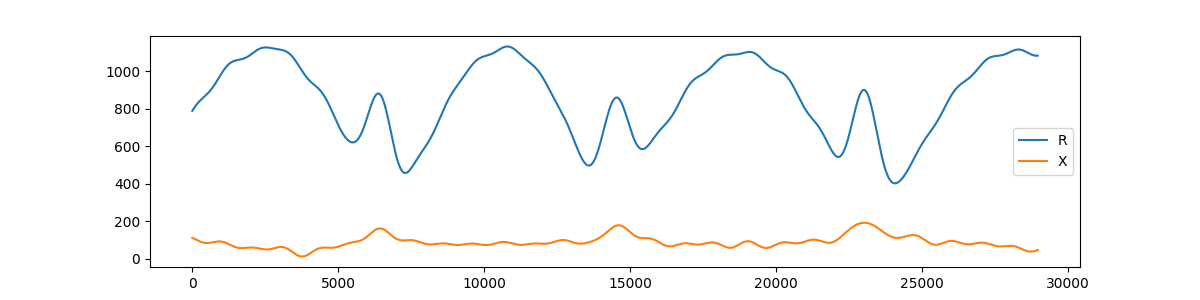

In [5]:
#firFilterBP = signal.firwin(201, cutoff = [10, 2000], window = "hamming", pass_zero = "bandpass", fs=sampleRate)
firFilterLP = signal.firwin(2001, cutoff = 1000, window = "hamming", pass_zero = "lowpass", fs=sampleRate)

fig = plt.figure(figsize=(12, 3))
def SampleAndPlotDiff(phaseOffset, xScale):
    print("X scale: ", xScale)
    offsetInSamples = int(round(phaseOffset / (math.pi*2) * sampleRate * 1.0 / frequency, 0))
    print("offset in samples: ", offsetInSamples)

    periodInSamples = int(round(sampleRate * 1.0 / frequency, 0))
    #print("period in samples: ", periodInSamples)
    quarterPeriodInSamples = int(round(math.pi/2 / (math.pi*2) * sampleRate * 1.0 / frequency, 0))
    #print("quarter period in samples: ", quarterPeriodInSamples)

    signalXList = []
    signalXIndicesList = []
    for i in range(offsetInSamples, numPoints, periodInSamples):
        signalXList.append(signalData[i])
        signalXIndicesList.append(i)
    signalX = np.asarray(signalXList)
    signalXIndices = np.asarray(signalXIndicesList)

    #NOTE: is this add or subtract a quarter period?
    signalRList = []
    signalRIndicesList = []
    for i in range(offsetInSamples + quarterPeriodInSamples, numPoints, periodInSamples):
        signalRList.append(signalData[i])
        signalRIndicesList.append(i)
    signalR = np.asarray(signalRList)
    signalRIndices = np.asarray(signalRIndicesList)

    #make arrays the same size
    if (signalR.size != signalX.size):
        minSize = min([signalR.size, signalX.size])
        signalR = signalR[0:minSize-1]
        signalX = signalX[0:minSize-1]

    signalX = signal.lfilter(firFilterLP, 1, signalX)
    signalR = signal.lfilter(firFilterLP, 1, signalR)
    
    ampR = np.max(signalR) - np.min(signalR)
    print("R amplitude: ", ampR)
    
    #seems to be better to filter X and R first, then calc phase (rather than calc phase from raw noisy X and R then filter results)
    #phase = np.degrees(np.unwrap(np.arctan2(signalX, signalR)))
    
    signalXNormalized = signalX - np.mean(signalX)
    signalRNormalized = signalR - np.mean(signalR)

    
    diff = (signalRNormalized) - (xScale*signalXNormalized)
    
    plt.clf()
    #plt.plot(phase[3000:-1])
    plt.plot(signalRNormalized[3000:-1], label="R")
    plt.plot(signalXNormalized[3000:-1], label="X")
    #plt.plot(diff[3000:-1], label="diff")
    plt.legend()
    fig.canvas.draw()

interact(SampleAndPlotDiff, 
         #phaseOffset=FloatSlider(min=0, max=2*math.pi, step=0.001, value=0.59, layout=Layout(width='100%')),
         phaseOffset=FloatSlider(min=0, max=2*math.pi, step=0.001, value=defaultPhaseOffsetValue, layout=Layout(width='100%')),
         xScale=FloatSlider(min=-3, max=3, step=0.01, value = 2.77, layout=Layout(width='100%'))
        )